# Project 1 (mushrooms dataset) - GroupID 26

## Import libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dirty_completeness import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [7]:
# Dark theme 
plt.style.use("dark_background")

In [8]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Set the seed

In [9]:
seed = 42

## Utils Functions

In [10]:
class ImputationCategorical:
    def __init__(self, name, classifier, imputer):
        self.name = name
        self.classifier = classifier
        self.imputer = imputer
        self.encoder = OrdinalEncoder()
        self.estimator = make_pipeline(self.imputer, self.classifier)
        self.accs = []
        self.stds = []
        self.accs_assessment = []
        self.y_labels = ["50%", "40%", "30%", "20%", "10%"]

    def accuracy_assessment(self, X_missing, X_full):
        # Accuracy assessment of imputation

        injected_indicator = self.imputer.fit_transform(X_missing)
        num_cols = X_missing.shape[1]
        # Extract the imputed data
        injected_array = injected_indicator[:, :num_cols]
        # extract the number of values equal between X_missing and X_full
        num_equal = np.sum(injected_array == X_full)
        total_values = X_full.shape[0] * X_full.shape[1]
        # accuracy assessment of imputation
        acc_ass = num_equal / total_values
        return acc_ass*100

    def get_scores_for_single_dataset(self, X_missing, y_missing, X_full):
        # Accuracy of the classifier with imputated data
        impute_scores = cross_val_score(
            self.estimator, X_missing, y_missing, scoring="accuracy", cv=4
        )
        # Accuracy assessment of imputation
        mse = self.accuracy_assessment(X_missing, X_full)

        mean_score = np.mean(impute_scores)
        std_score = np.std(impute_scores)

        self.accs.append(mean_score)
        self.stds.append(std_score)
        self.accs_assessment.append(mse)

        return mean_score, std_score, mse

    def get_scores_for_full_dataset(self, original_dataset, dirty_dataset):
        # Accuracy of the classifier with imputated data
        for dirty_df in dirty_dataset:
            dirty_np = self.encoder.fit_transform(dirty_df)
            X_missing = dirty_np[:, :-1]
            y_missing = dirty_np[:, -1]
            original_dataset = self.encoder.fit_transform(original_dataset)
            X_full = original_dataset[:, :-1]
            self.get_scores_for_single_dataset(X_missing, y_missing, X_full)

        return self.accs, self.stds, self.accs_assessment

    # Print the accuracy of the classifier with imputated data and the accuracy assessment of imputation
    def print_imputation(self, acc_original, std_original):
        print("Accuracy of the classifier with complete data: {:.3f} ± {:.3f}".format(acc_original, std_original))
        print()
        for i in range(len(self.accs)):
            print(
                "Accuracy of the classifier with imputated data with "
                + self.y_labels[i]
                + " missing values: {:.3f} ± {:.3f}".format(self.accs[i], self.stds[i])
            )
        print()
        for i in range(len(self.accs_assessment)):
            print(
                "Accuracy assessment of imputation with "
                + self.y_labels[i]
                + " missing values: {:.3f}".format(self.accs_assessment[i])
                + "%"
            )

    def plot_imputation(self, acc_original, std_original):
        colors = ["r", "g", "b", "orange", "black"]

        # plot diabetes results
        plt.figure(figsize=(12, 6))
        
        ax1 = plt.subplot(121)
        ax1.barh(
            "Original",
            acc_original,
            xerr=std_original,
            color="purple",
            label="Original",
            alpha=0.6,
            align="center",
        )
        for j in range(len(self.accs)):
            ax1.barh(
                self.y_labels[j],
                self.accs[j],
                xerr=self.stds[j],
                color=colors[j],
                label=self.y_labels[j],
                alpha=0.6,
                align="center",
            )

        ax1.set_xlabel("Accuracy of the classifier")
        ax1.set_ylabel("Percentage of missing values")
        ax1.set_xlim(left=np.min(self.accs) - 0.1, right=1)
        ax1.invert_yaxis()

        ax2 = plt.subplot(122)
        for j in range(len(self.accs_assessment)):
            ax2.barh(
                self.y_labels[j],
                self.accs_assessment[j],
                color=colors[j],
                label=self.y_labels[j],
                alpha=0.6,
                align="center",
            )

        ax2.set_xlabel("Accuracy assessment of imputation")
        ax2.set_xlim(left=np.min(self.accs_assessment) * 0.9, right=100)
        ax2.invert_yaxis()

        plt.suptitle("Imputation of missing values with " + self.name)
        plt.tight_layout()
        plt.show()

    def plot_imputation_errorbar(self):
        # Plot the accuracy of the classifier with imputated data
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            self.y_labels,
            self.accs,
            yerr=self.stds,
            fmt="o",
            capsize=5,
            capthick=2,
            ecolor="red",
            elinewidth=3,
            color="blue",
            label="Accuracy of the classifier with imputated data",
        )
        plt.xlabel("Percentage of missing values")
        plt.ylabel("Accuracy")
        plt.title("Imputation of missing values with " + self.name)
        plt.legend()
        plt.show()

        # Plot the accuracy assessment of imputation
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            self.y_labels,
            self.accs_assessment,
            fmt="o",
            capsize=5,
            capthick=2,
            ecolor="red",
            elinewidth=3,
            color="blue",
            label="Accuracy assessment of imputation",
        )
        plt.xlabel("Percentage of missing values")
        plt.ylabel("MSE")
        plt.title("Imputation of missing values with " + self.name)
        plt.legend()
        plt.show()

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_distribution_categorical(df1, df2):
  # Get the list of column names
  cols = df1.columns

  # Set the number of rows and columns for the subplot grid
  nrows = len(cols)
  ncols = 1

  # Set the figure size
  plt.figure(figsize=(10, 6 * nrows))

  # Iterate through the columns
  for i, col in enumerate(cols):
    # Get the counts of each unique value in the column
    counts1 = df1[col].value_counts()
    counts2 = df2[col].value_counts()
    
    name_label = ['No missing values', 'With missing values']

    # Plot the counts on a bar chart
    ax = plt.subplot(nrows, ncols, i + 1)
    counts1.plot(kind='bar', ax=ax, color='blue', edgecolor='black', label='No missing values', alpha=0.5)
    counts2.plot(kind='bar', ax=ax, color='red', edgecolor='black', label='With missing values', alpha = 0.5)
    ax.set_title(col)
    leg = ax.legend(name_label)
    for text in leg.get_texts():
      text.set_color("black")

  plt.tight_layout()
  plt.show()


In [12]:
def get_full_score(classifier, X_full, y_full):
    impute_scores = cross_val_score(
        classifier, X_full, y_full, scoring="accuracy", cv=4
    )
    return impute_scores.mean(), impute_scores.std()


In [13]:
# Function to visualize where the missing values are for each column
def visualize_missing_values(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(df.isnull(), cbar=False)
    plt.show()

## Import the *mushrooms* dataset

In [14]:
mush_df = pd.read_csv("mushrooms.csv")
mush_df.head()

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,...,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat,Class
0,flat,scaly,red,False,fishy,free,close,narrow,buff,tapering,...,pink,pink,partial,white,one,evanescent,white,several,leaves,poisonous
1,convex,fibrous,white,False,none,free,crowded,broad,gray,enlarging,...,white,white,partial,white,two,pendant,white,scattered,grasses,edible
2,convex,fibrous,white,False,none,free,crowded,broad,black,tapering,...,white,white,partial,white,one,evanescent,black,abundant,grasses,edible
3,flat,fibrous,gray,False,none,free,crowded,broad,brown,tapering,...,white,white,partial,white,one,evanescent,black,abundant,grasses,edible
4,convex,smooth,red,False,foul,free,close,narrow,buff,tapering,...,pink,pink,partial,white,one,evanescent,white,several,paths,poisonous


In [15]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CapShape               2010 non-null   object
 1   CapSurface             2010 non-null   object
 2   CapColor               2010 non-null   object
 3   Bruises                2010 non-null   bool  
 4   Odor                   2010 non-null   object
 5   GillAttachment         2010 non-null   object
 6   GillSpacing            2010 non-null   object
 7   GillSize               2010 non-null   object
 8   GillColor              2010 non-null   object
 9   StalkShape             2010 non-null   object
 10  StalkRoot              2010 non-null   object
 11  StalkSurfaceAboveRing  2010 non-null   object
 12  StalkSurfaceBelowRing  2010 non-null   object
 13  StalkColorAboveRing    2010 non-null   object
 14  StalkColorBelowRing    2010 non-null   object
 15  VeilType             

In [16]:
# Labels in Class column
mush_df["Class"].unique()

array(['poisonous', 'edible'], dtype=object)

## Data Profiling

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



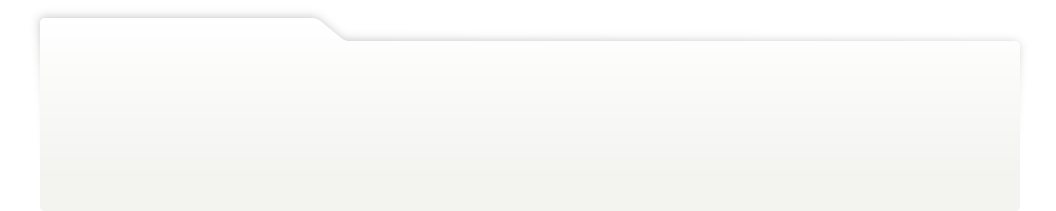
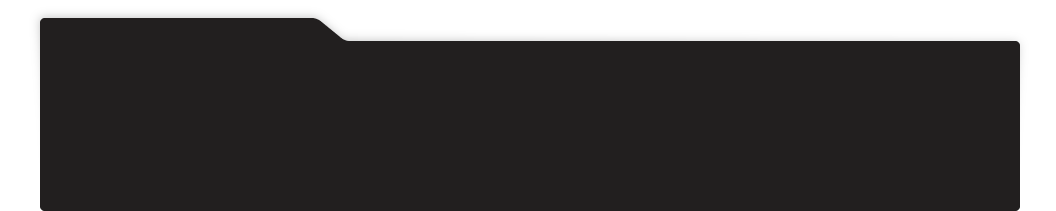
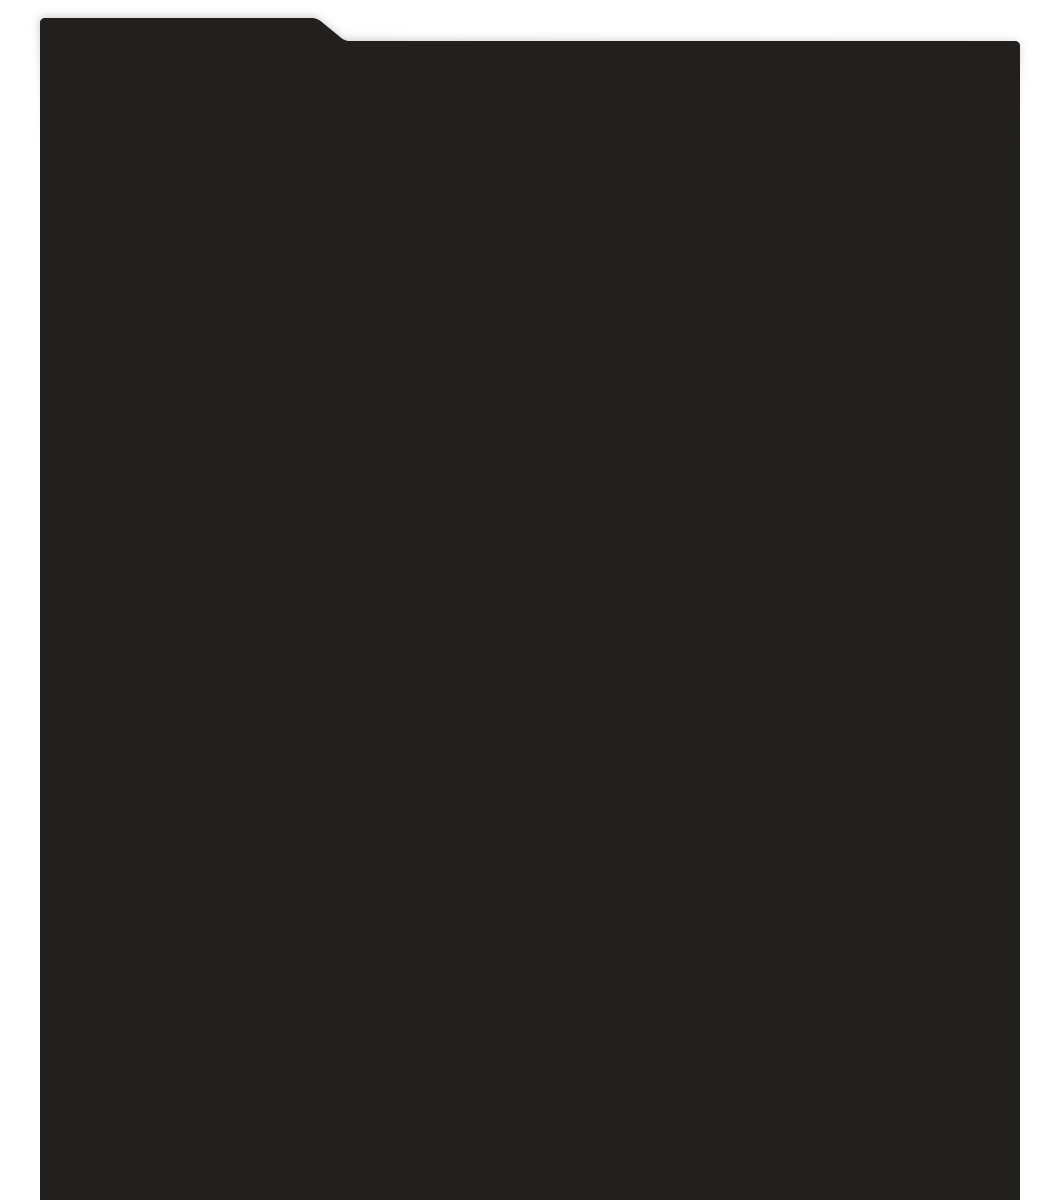
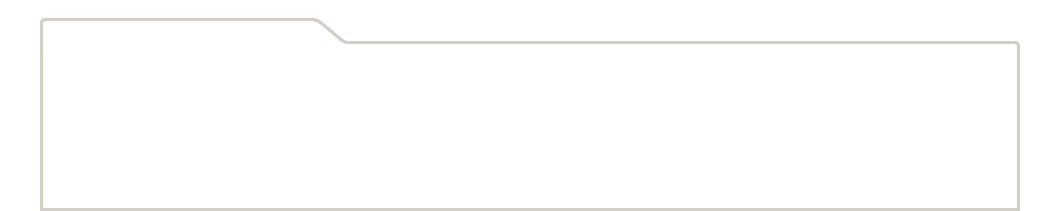
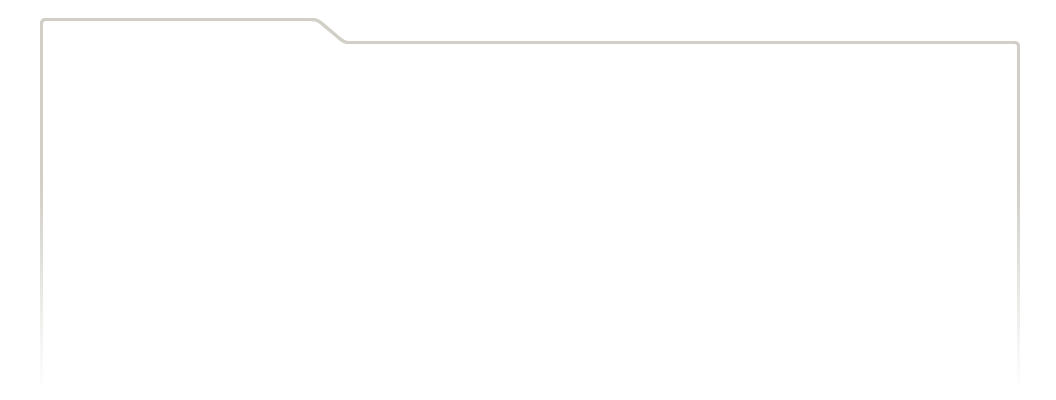
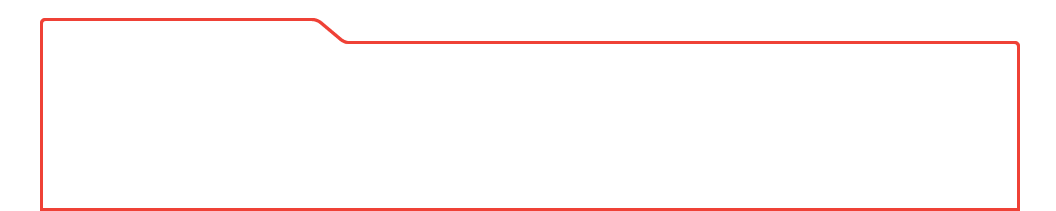
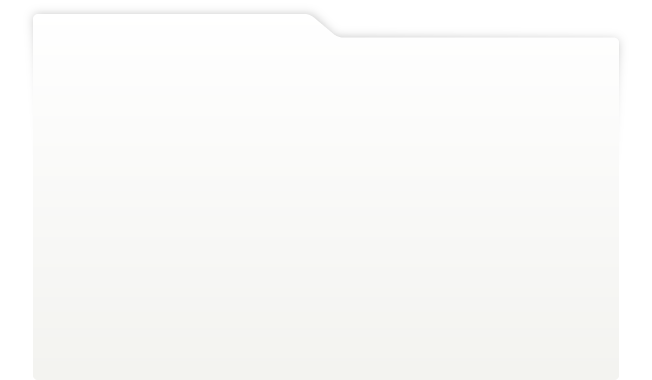
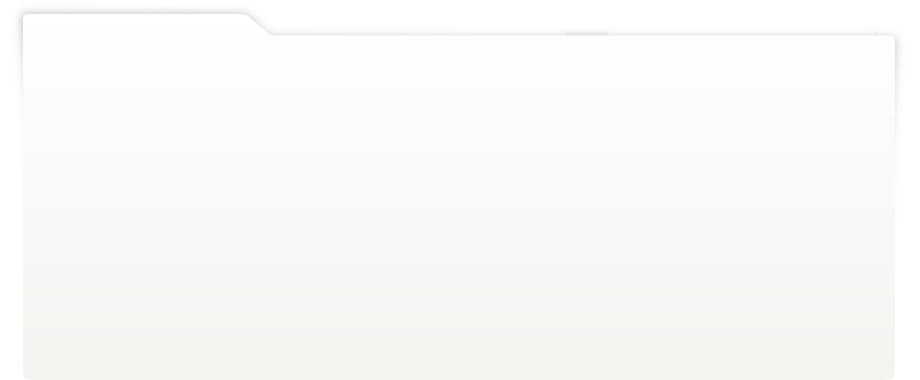
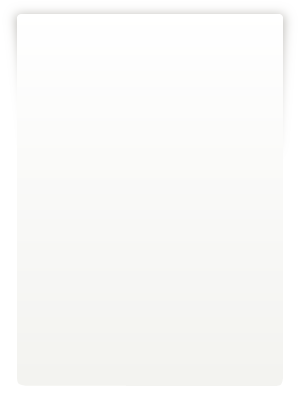
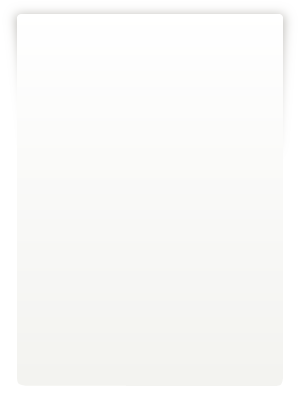
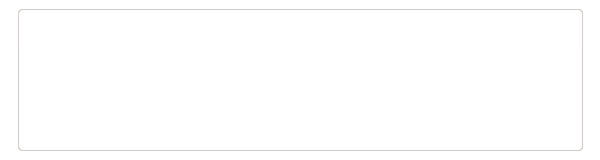
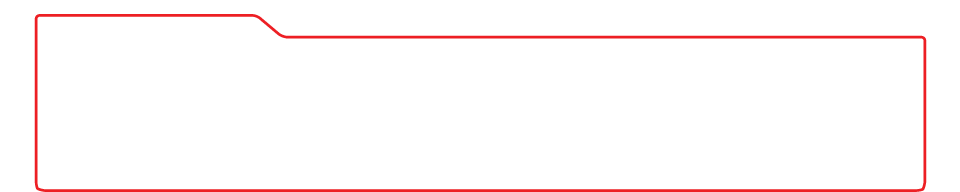
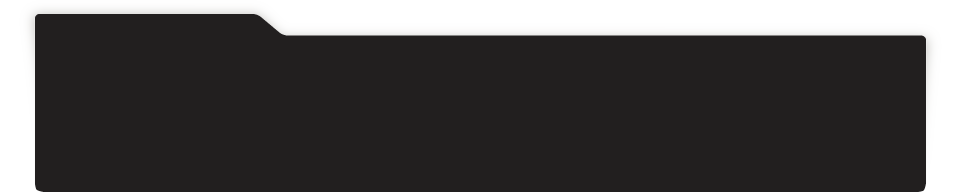
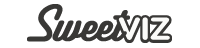
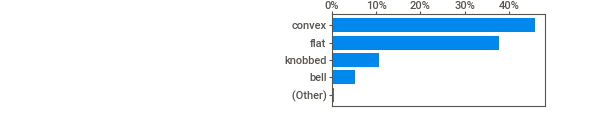
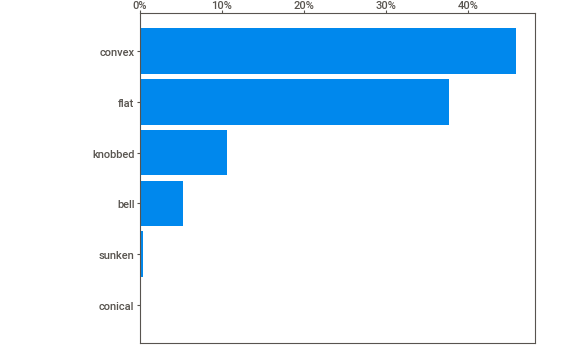
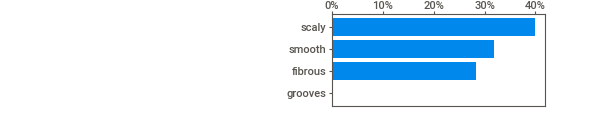
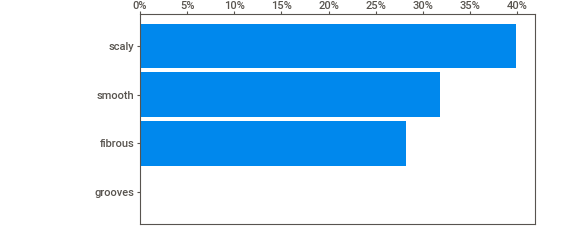
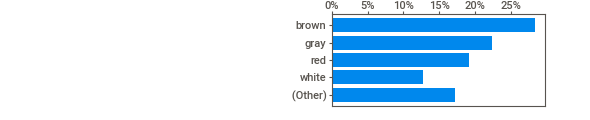
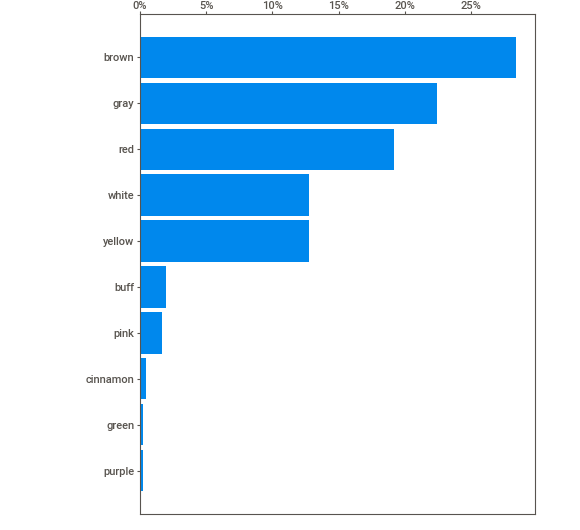
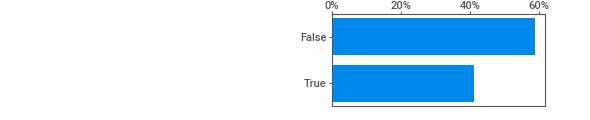
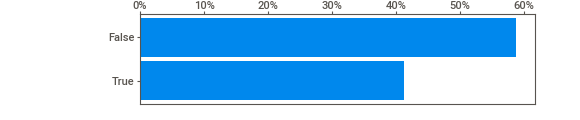
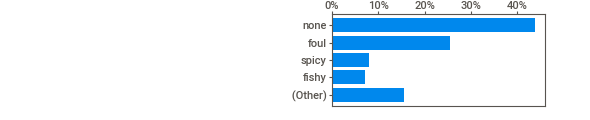
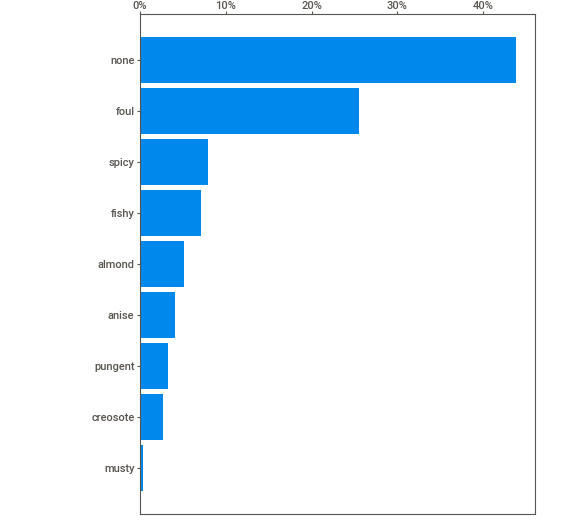
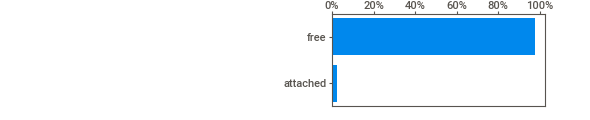
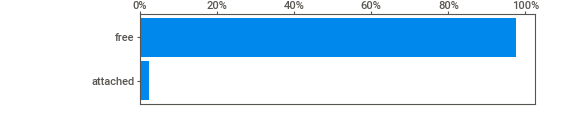
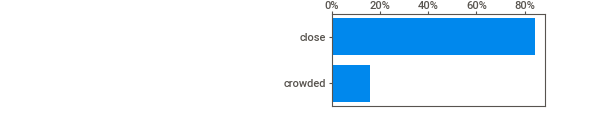
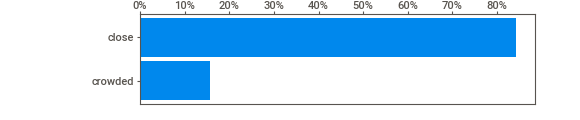
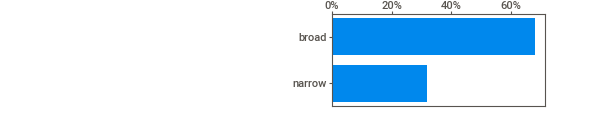
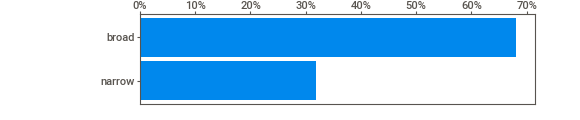
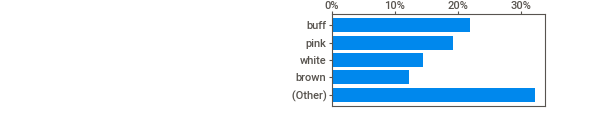
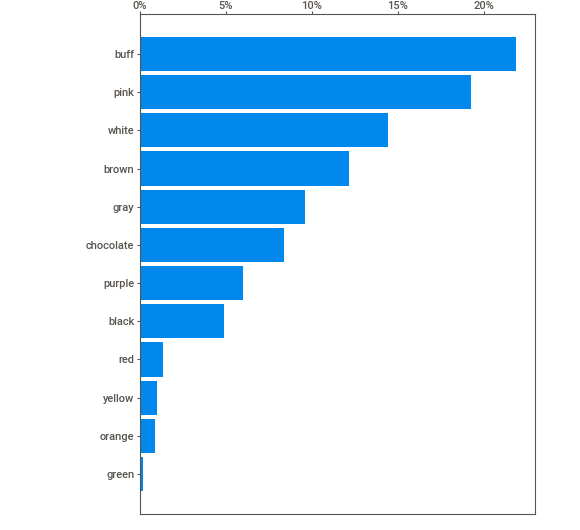
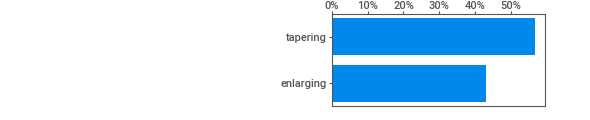
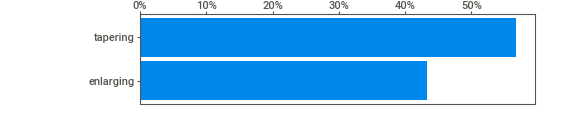
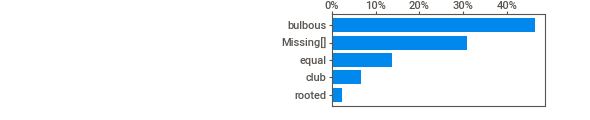
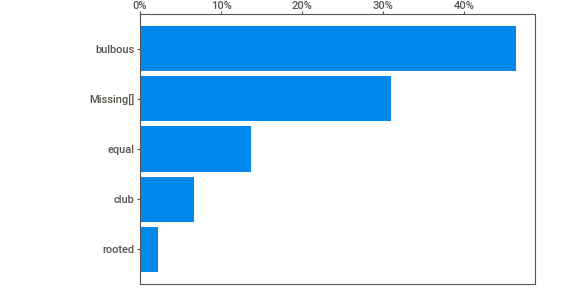
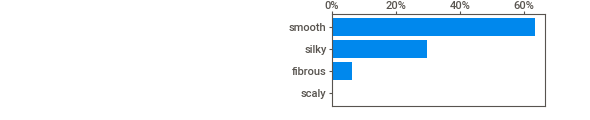
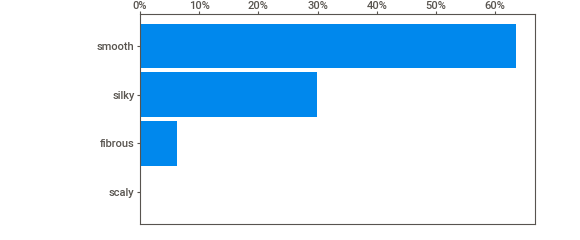
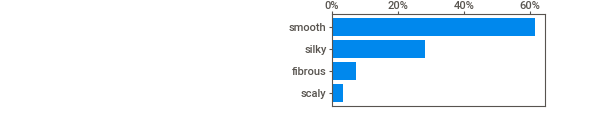
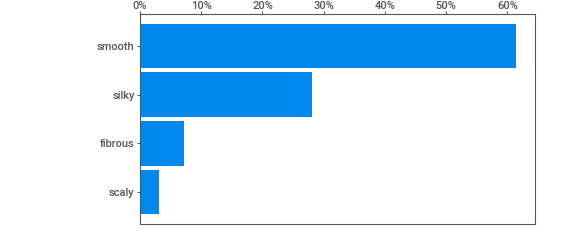
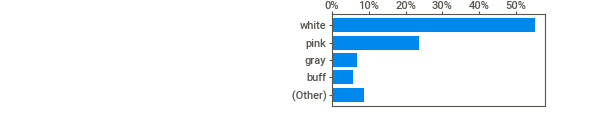
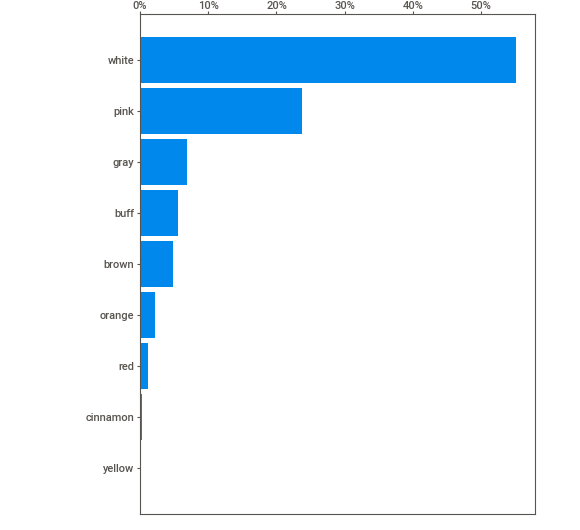
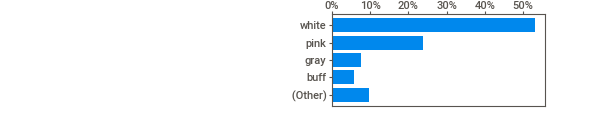
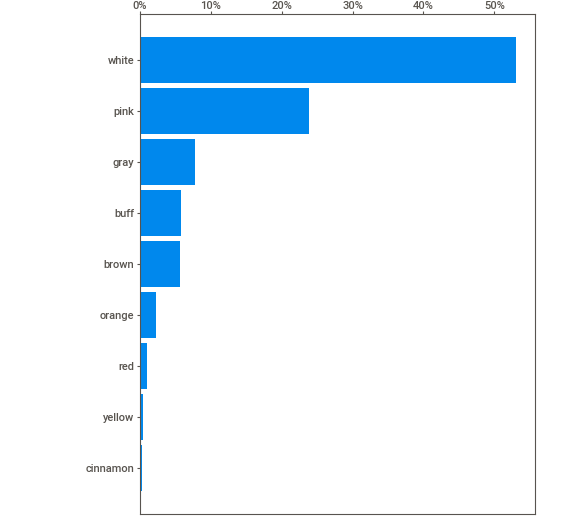
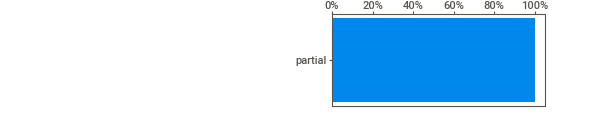
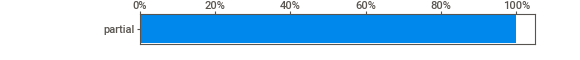
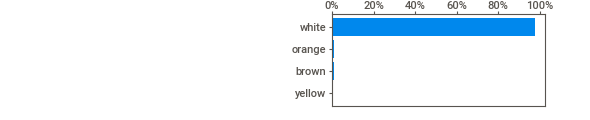
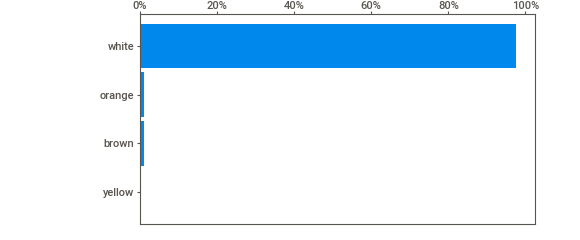
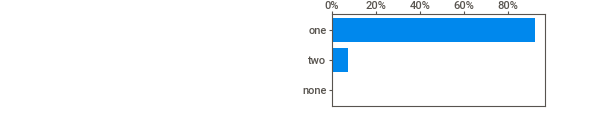
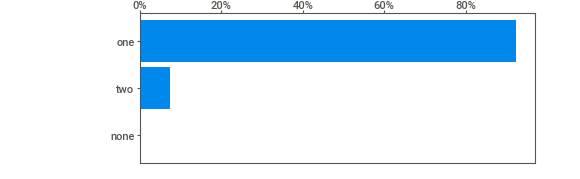
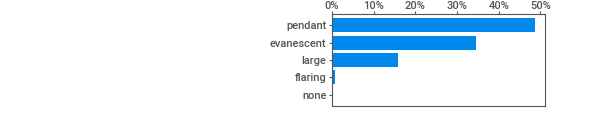
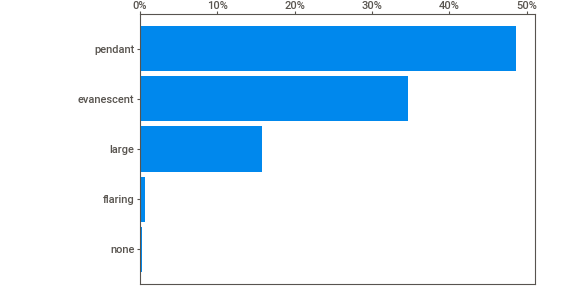
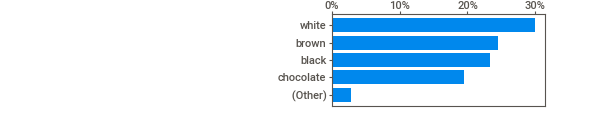
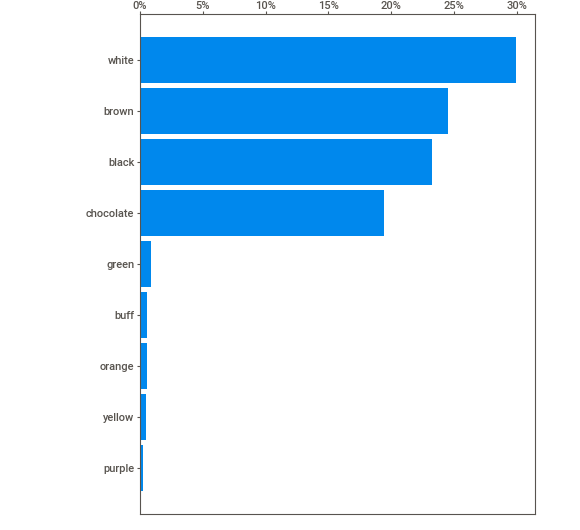
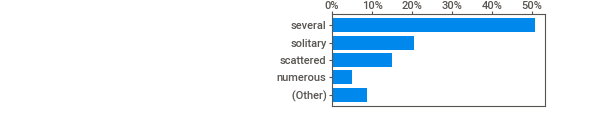
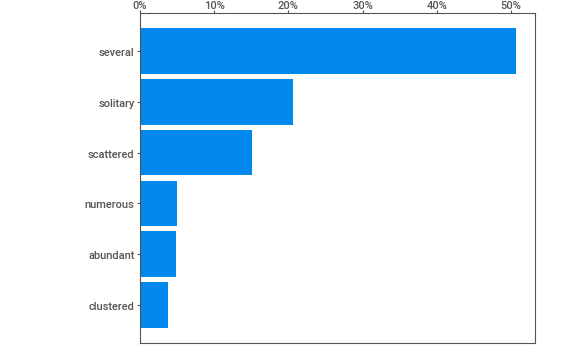
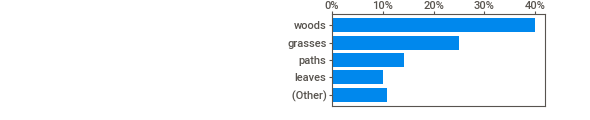
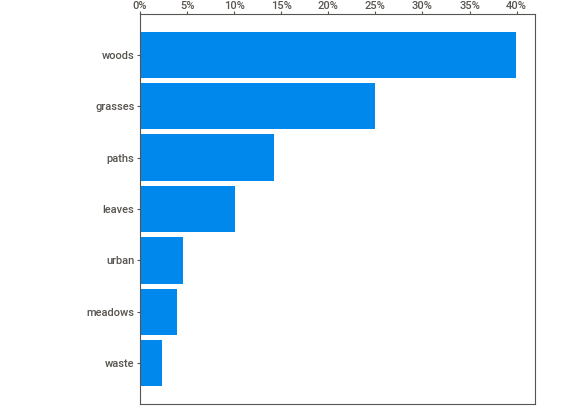
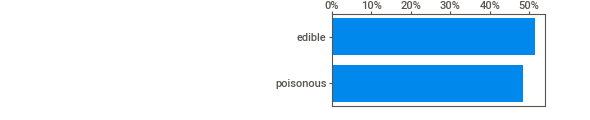
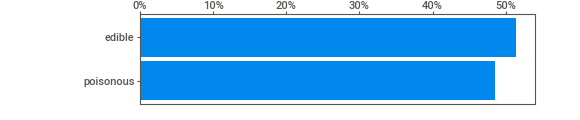
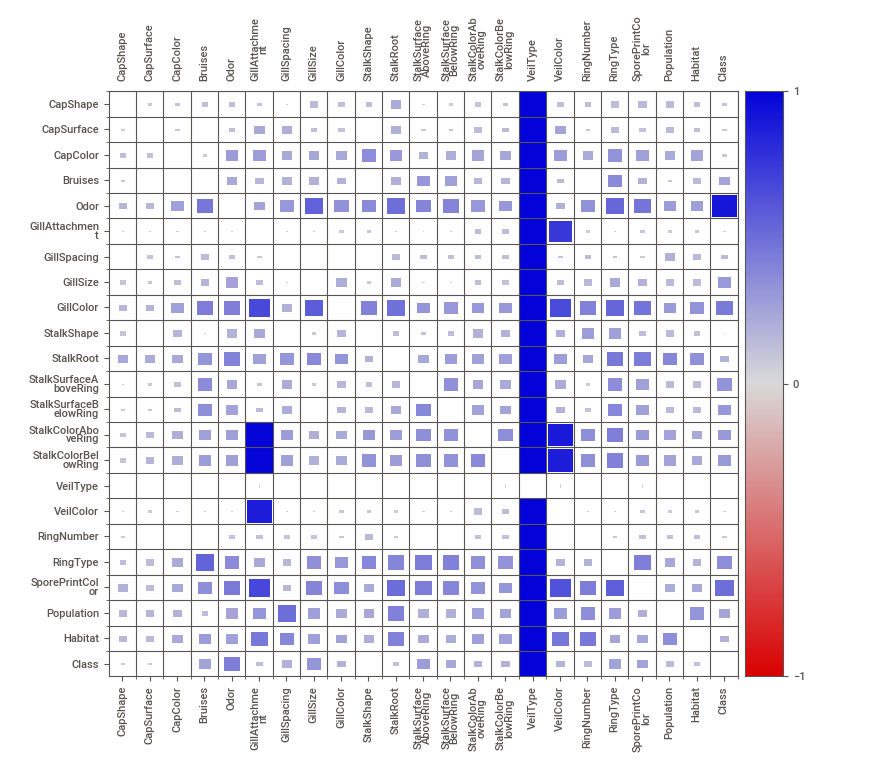
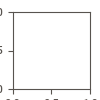

In [413]:
# data profiling with sweetviz
import sweetviz as sv
mush_report_enc = sv.analyze(mush_df)
mush_report_enc.show_notebook()

## Injection of missing values

In [17]:
dirty_mush = injection(df_pandas=mush_df,seed=seed,name="mushrooms",name_class="Class")

saved mushrooms-completeness50%
saved mushrooms-completeness60%
saved mushrooms-completeness70%
saved mushrooms-completeness80%
saved mushrooms-completeness90%


In [18]:
dirty_mush[4].isnull().sum()

CapShape                 192
CapSurface               189
CapColor                 197
Bruises                  208
Odor                     217
GillAttachment           196
GillSpacing              202
GillSize                 199
GillColor                200
StalkShape               191
StalkRoot                184
StalkSurfaceAboveRing    211
StalkSurfaceBelowRing    224
StalkColorAboveRing      211
StalkColorBelowRing      214
VeilType                 216
VeilColor                209
RingNumber               204
RingType                 185
SporePrintColor          203
Population               204
Habitat                  198
Class                      0
dtype: int64

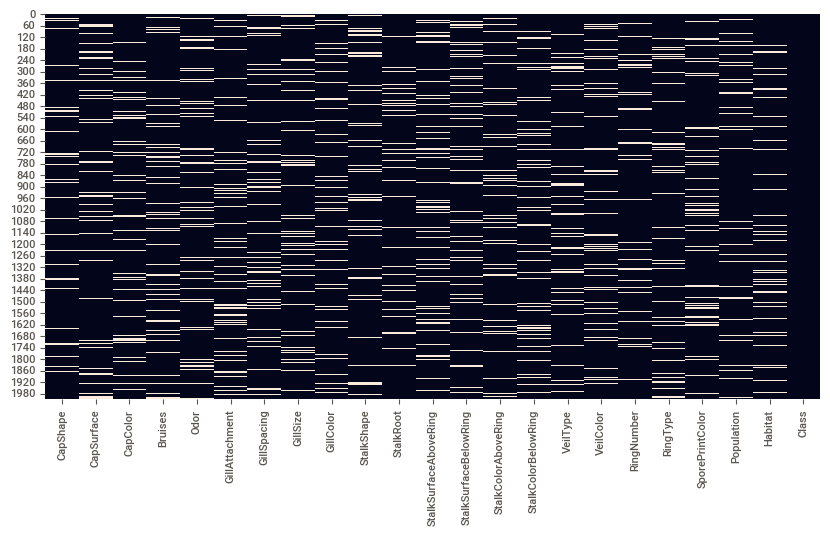

In [416]:
visualize_missing_values(dirty_mush[4])

#### visualize distripution with 40% of missing values

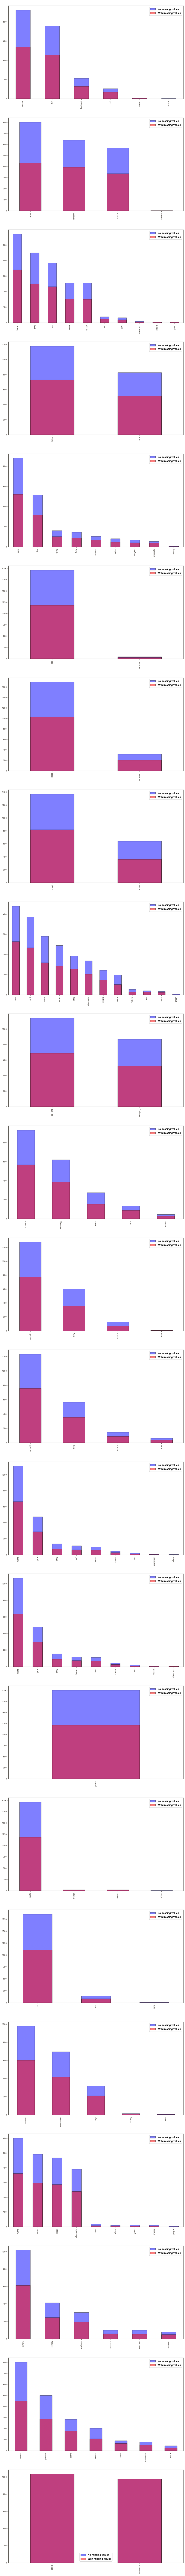

In [417]:
visualize_distribution_categorical(mush_df, dirty_mush[1])

## Encoding of the dataset

In [418]:
# Encoding of the data
encoder = OrdinalEncoder()
grad_boost = GradientBoostingClassifier(random_state=seed)
mush_df_encoded = encoder.fit_transform(mush_df)
X_full = mush_df_encoded[:, :-1]
y_full = mush_df_encoded[:, -1]
acc_original, std_original = get_full_score(grad_boost, X_full, y_full)

# Accuracy assessment and ML performances

## Imputation Standard Techniques - Mode (most frequent)

#### Machine Learning alghoritm: Gradient Boosting

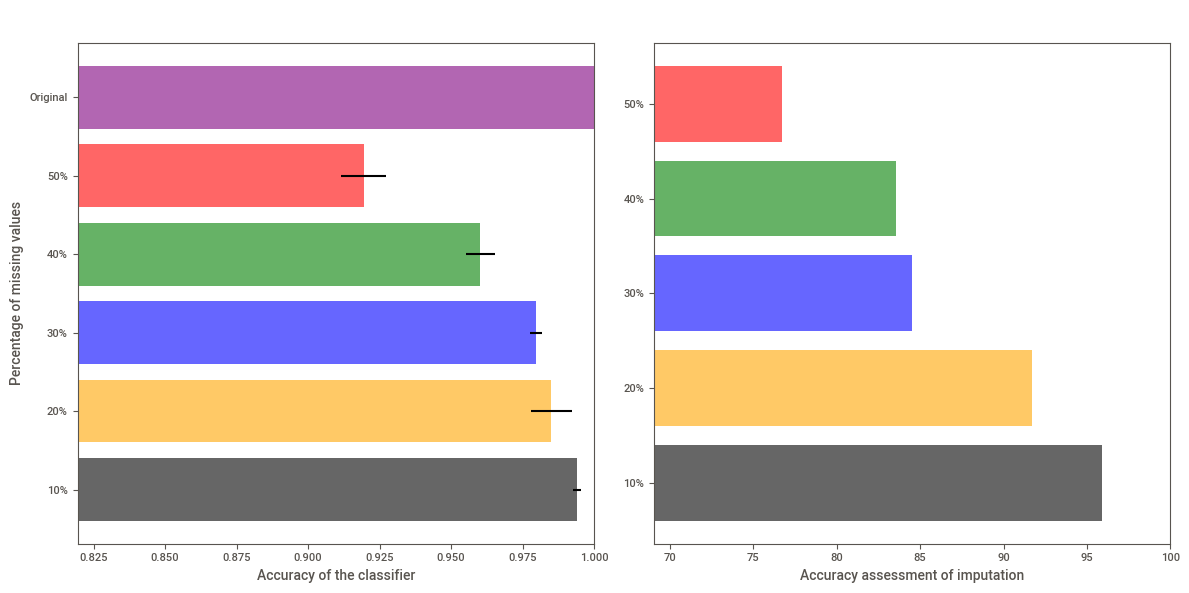

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.919 ± 0.008
Accuracy of the classifier with imputated data with 40% missing values: 0.960 ± 0.005
Accuracy of the classifier with imputated data with 30% missing values: 0.980 ± 0.002
Accuracy of the classifier with imputated data with 20% missing values: 0.985 ± 0.007
Accuracy of the classifier with imputated data with 10% missing values: 0.994 ± 0.001

Accuracy assessment of imputation with 50% missing values: 76.732%
Accuracy assessment of imputation with 40% missing values: 83.530%
Accuracy assessment of imputation with 30% missing values: 84.491%
Accuracy assessment of imputation with 20% missing values: 91.694%
Accuracy assessment of imputation with 10% missing values: 95.925%


In [419]:
# Impute the missing values with the mode
simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

grad_boost = GradientBoostingClassifier(random_state=seed)

imp = ImputationCategorical(
    name="ModeImputer",
    imputer=simple_imputer,
    classifier=grad_boost
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: Logistic Regression

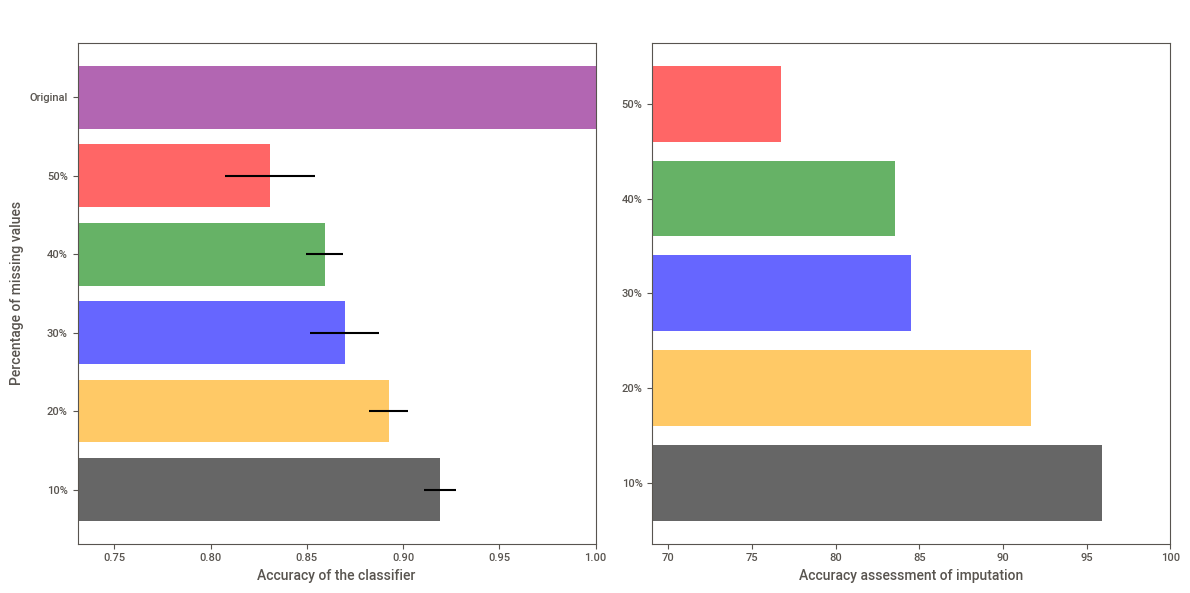

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.831 ± 0.023
Accuracy of the classifier with imputated data with 40% missing values: 0.859 ± 0.010
Accuracy of the classifier with imputated data with 30% missing values: 0.870 ± 0.018
Accuracy of the classifier with imputated data with 20% missing values: 0.893 ± 0.010
Accuracy of the classifier with imputated data with 10% missing values: 0.919 ± 0.008

Accuracy assessment of imputation with 50% missing values: 76.732%
Accuracy assessment of imputation with 40% missing values: 83.530%
Accuracy assessment of imputation with 30% missing values: 84.491%
Accuracy assessment of imputation with 20% missing values: 91.694%
Accuracy assessment of imputation with 10% missing values: 95.925%


In [420]:
# Impute the missing values with the mode
simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

log_reg = LogisticRegression(random_state=seed)

imp = ImputationCategorical(
    name="ModeImputer",
    imputer=simple_imputer,
    classifier=log_reg
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: SVC (Support Vector Classifier)

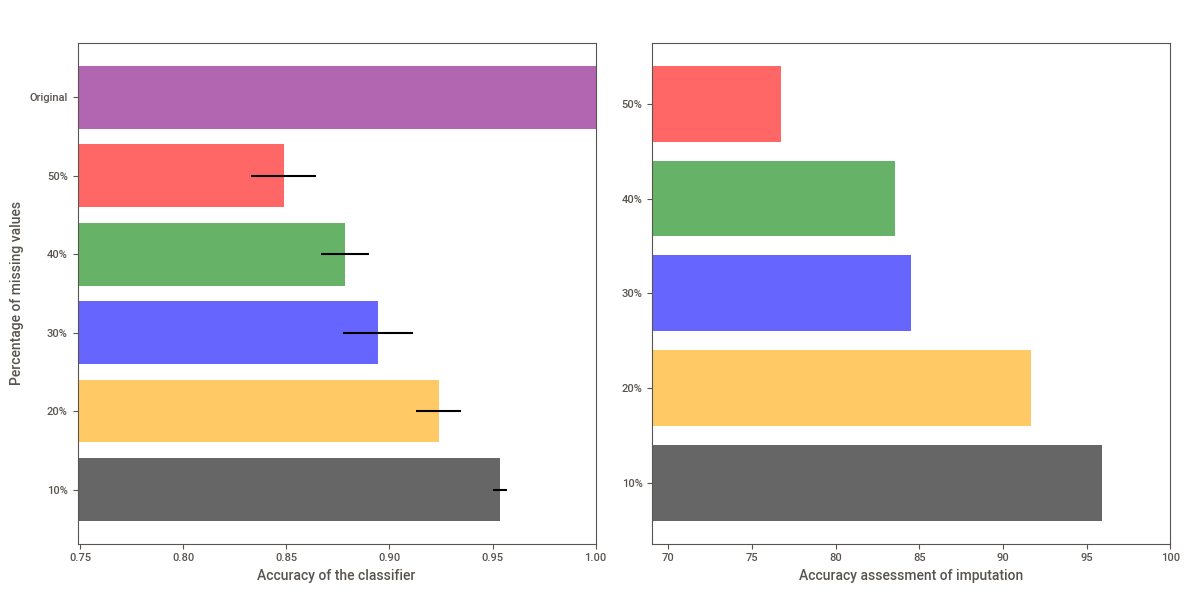

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.849 ± 0.016
Accuracy of the classifier with imputated data with 40% missing values: 0.879 ± 0.012
Accuracy of the classifier with imputated data with 30% missing values: 0.895 ± 0.017
Accuracy of the classifier with imputated data with 20% missing values: 0.924 ± 0.011
Accuracy of the classifier with imputated data with 10% missing values: 0.954 ± 0.003

Accuracy assessment of imputation with 50% missing values: 76.732%
Accuracy assessment of imputation with 40% missing values: 83.530%
Accuracy assessment of imputation with 30% missing values: 84.491%
Accuracy assessment of imputation with 20% missing values: 91.694%
Accuracy assessment of imputation with 10% missing values: 95.925%


In [421]:
# Impute the missing values with the mode
simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

svc = SVC(random_state=seed)

imp = ImputationCategorical(
    name="ModeImputer",
    imputer=simple_imputer,
    classifier=svc
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

## Imputation Advanced Techniques - KNN K-Nearest Neighbors

#### Machine Learning alghoritm: Gradient Boosting

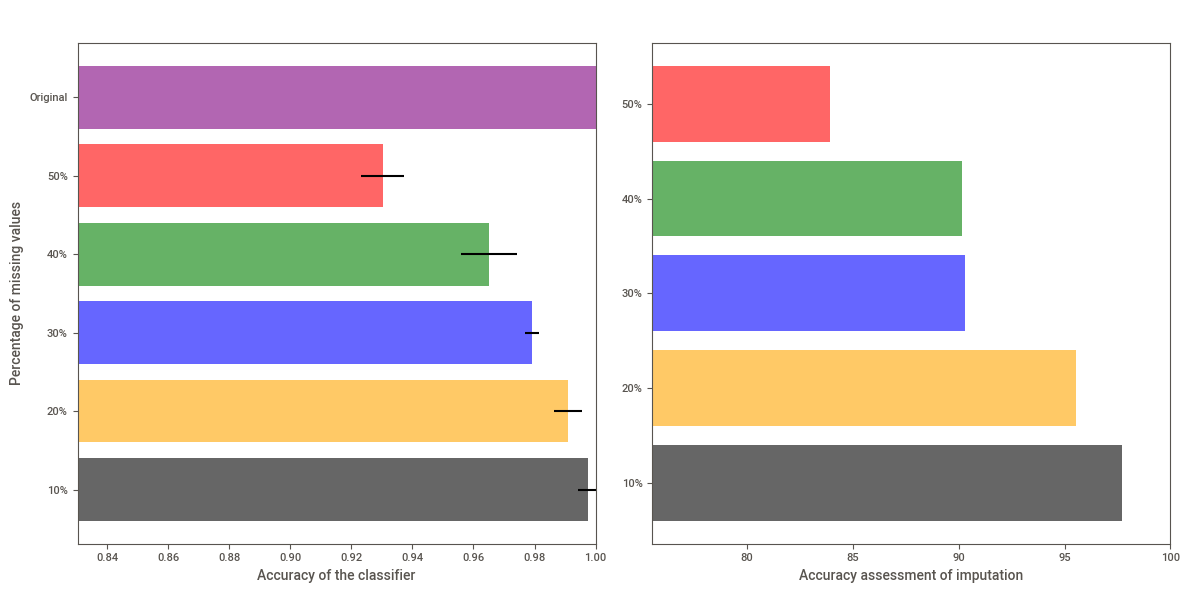

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.930 ± 0.007
Accuracy of the classifier with imputated data with 40% missing values: 0.965 ± 0.009
Accuracy of the classifier with imputated data with 30% missing values: 0.979 ± 0.002
Accuracy of the classifier with imputated data with 20% missing values: 0.991 ± 0.005
Accuracy of the classifier with imputated data with 10% missing values: 0.998 ± 0.003

Accuracy assessment of imputation with 50% missing values: 83.924%
Accuracy assessment of imputation with 40% missing values: 90.170%
Accuracy assessment of imputation with 30% missing values: 90.294%
Accuracy assessment of imputation with 20% missing values: 95.547%
Accuracy assessment of imputation with 10% missing values: 97.709%


In [422]:
imputer = IterativeImputer(
    estimator=KNeighborsClassifier(n_neighbors=1),
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

grad_boost = GradientBoostingClassifier(random_state=seed)

imp = ImputationCategorical(
    name="KNNImputer",
    imputer=imputer,
    classifier=grad_boost
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: Logistic Regression

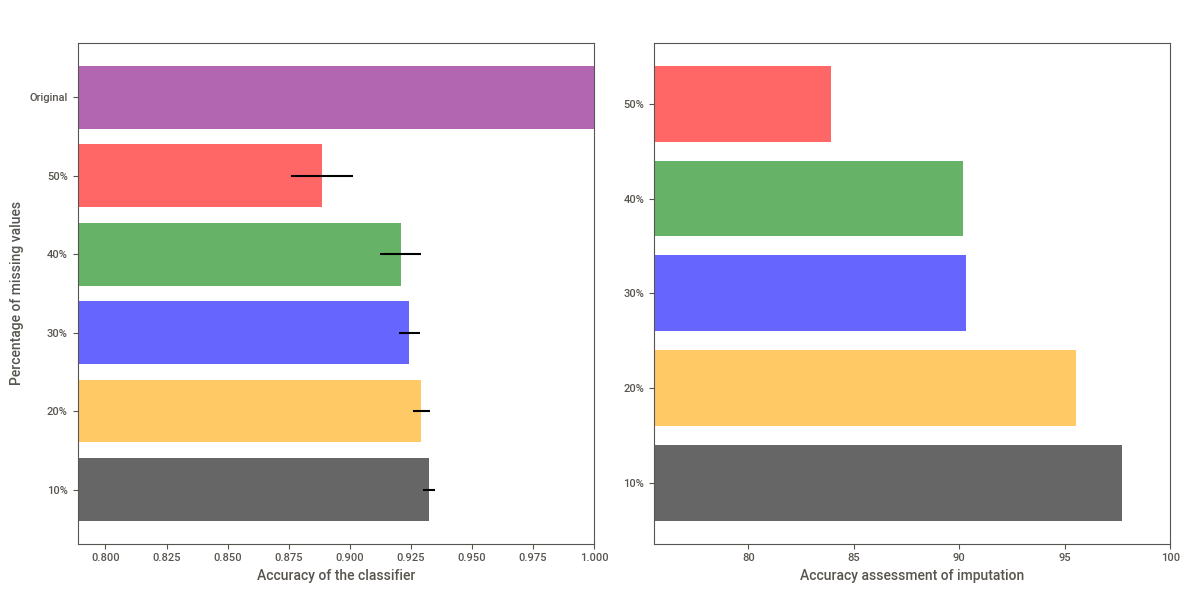

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.889 ± 0.013
Accuracy of the classifier with imputated data with 40% missing values: 0.921 ± 0.008
Accuracy of the classifier with imputated data with 30% missing values: 0.924 ± 0.004
Accuracy of the classifier with imputated data with 20% missing values: 0.929 ± 0.004
Accuracy of the classifier with imputated data with 10% missing values: 0.932 ± 0.002

Accuracy assessment of imputation with 50% missing values: 83.924%
Accuracy assessment of imputation with 40% missing values: 90.170%
Accuracy assessment of imputation with 30% missing values: 90.294%
Accuracy assessment of imputation with 20% missing values: 95.547%
Accuracy assessment of imputation with 10% missing values: 97.709%


In [423]:
imputer = IterativeImputer(
    estimator=KNeighborsClassifier(n_neighbors=1),
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

log_reg = LogisticRegression(random_state=seed)

imp = ImputationCategorical(
    name="KNNImputer",
    imputer=imputer,
    classifier=log_reg
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: SVC (Support Vector Classifier)

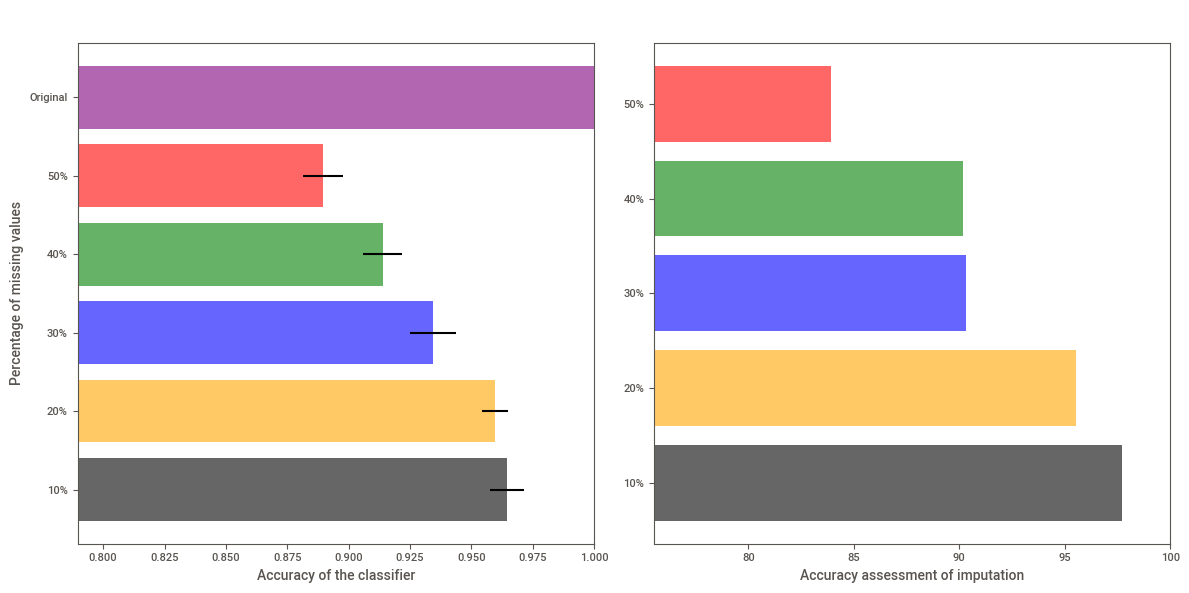

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.890 ± 0.008
Accuracy of the classifier with imputated data with 40% missing values: 0.914 ± 0.008
Accuracy of the classifier with imputated data with 30% missing values: 0.934 ± 0.009
Accuracy of the classifier with imputated data with 20% missing values: 0.960 ± 0.005
Accuracy of the classifier with imputated data with 10% missing values: 0.965 ± 0.007

Accuracy assessment of imputation with 50% missing values: 83.924%
Accuracy assessment of imputation with 40% missing values: 90.170%
Accuracy assessment of imputation with 30% missing values: 90.294%
Accuracy assessment of imputation with 20% missing values: 95.547%
Accuracy assessment of imputation with 10% missing values: 97.709%


In [424]:
imputer = IterativeImputer(
    estimator=KNeighborsClassifier(n_neighbors=1),
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

svc = SVC(random_state=seed)

imp = ImputationCategorical(
    name="KNNImputer",
    imputer=imputer,
    classifier=svc
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

## Imputation Advanced Techniques - Random Forest

#### Machine Learning alghoritm: Gradient Boosting

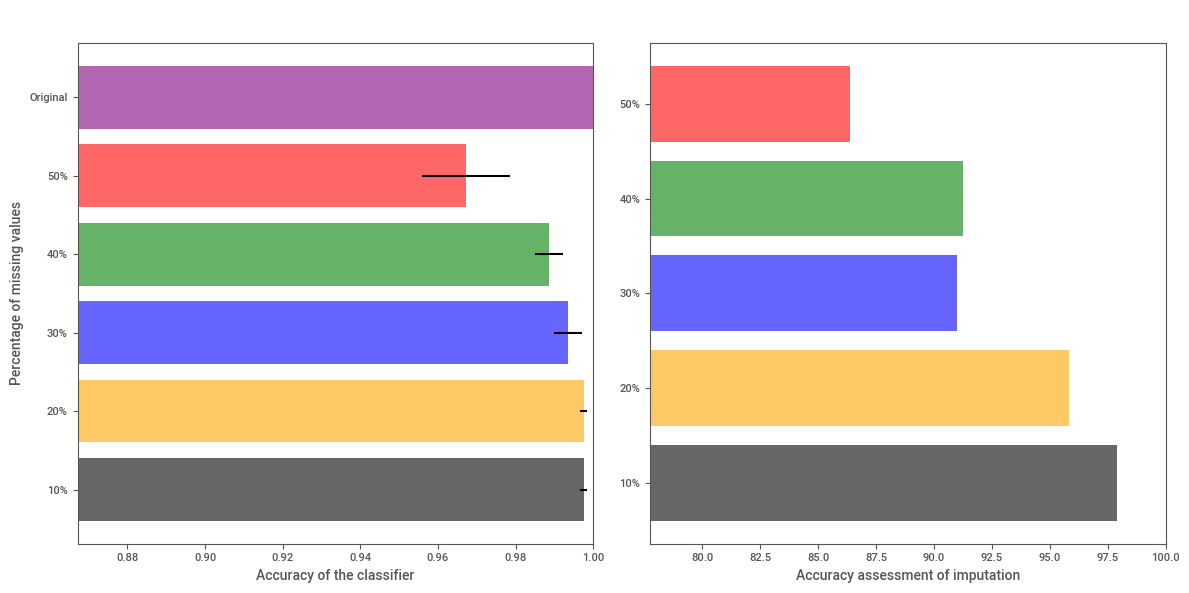

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.967 ± 0.011
Accuracy of the classifier with imputated data with 40% missing values: 0.989 ± 0.004
Accuracy of the classifier with imputated data with 30% missing values: 0.994 ± 0.004
Accuracy of the classifier with imputated data with 20% missing values: 0.998 ± 0.001
Accuracy of the classifier with imputated data with 10% missing values: 0.998 ± 0.001

Accuracy assessment of imputation with 50% missing values: 86.373%
Accuracy assessment of imputation with 40% missing values: 91.253%
Accuracy assessment of imputation with 30% missing values: 90.975%
Accuracy assessment of imputation with 20% missing values: 95.825%
Accuracy assessment of imputation with 10% missing values: 97.919%


In [425]:
imputer = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=seed,
    ), 
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

grad_boost = GradientBoostingClassifier(random_state=seed)

imp = ImputationCategorical(
    name="RandomForest",
    imputer=imputer,
    classifier=grad_boost
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: Logistic Regression

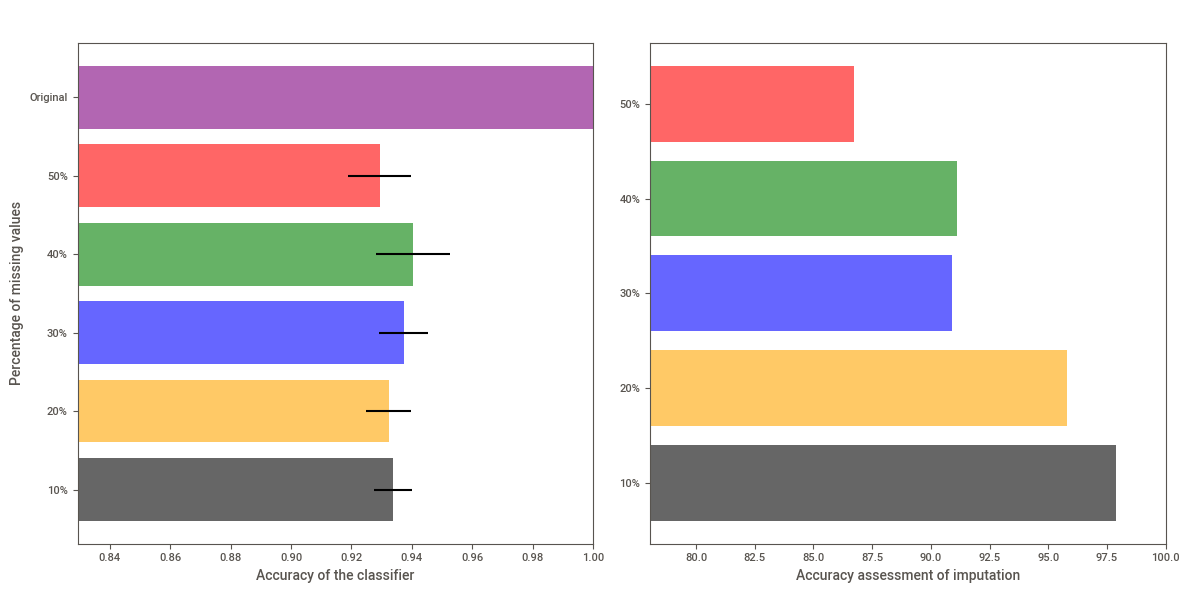

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.929 ± 0.010
Accuracy of the classifier with imputated data with 40% missing values: 0.940 ± 0.012
Accuracy of the classifier with imputated data with 30% missing values: 0.937 ± 0.008
Accuracy of the classifier with imputated data with 20% missing values: 0.932 ± 0.007
Accuracy of the classifier with imputated data with 10% missing values: 0.934 ± 0.006

Accuracy assessment of imputation with 50% missing values: 86.710%
Accuracy assessment of imputation with 40% missing values: 91.126%
Accuracy assessment of imputation with 30% missing values: 90.918%
Accuracy assessment of imputation with 20% missing values: 95.785%
Accuracy assessment of imputation with 10% missing values: 97.890%


In [426]:
imputer = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=seed,
    ), 
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

log_reg = LogisticRegression(random_state=seed)

imp = ImputationCategorical(
    name="KNNImputer",
    imputer=imputer,
    classifier=log_reg
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

#### Machine Learning algorithm: SVC (Support Vector Classifier)

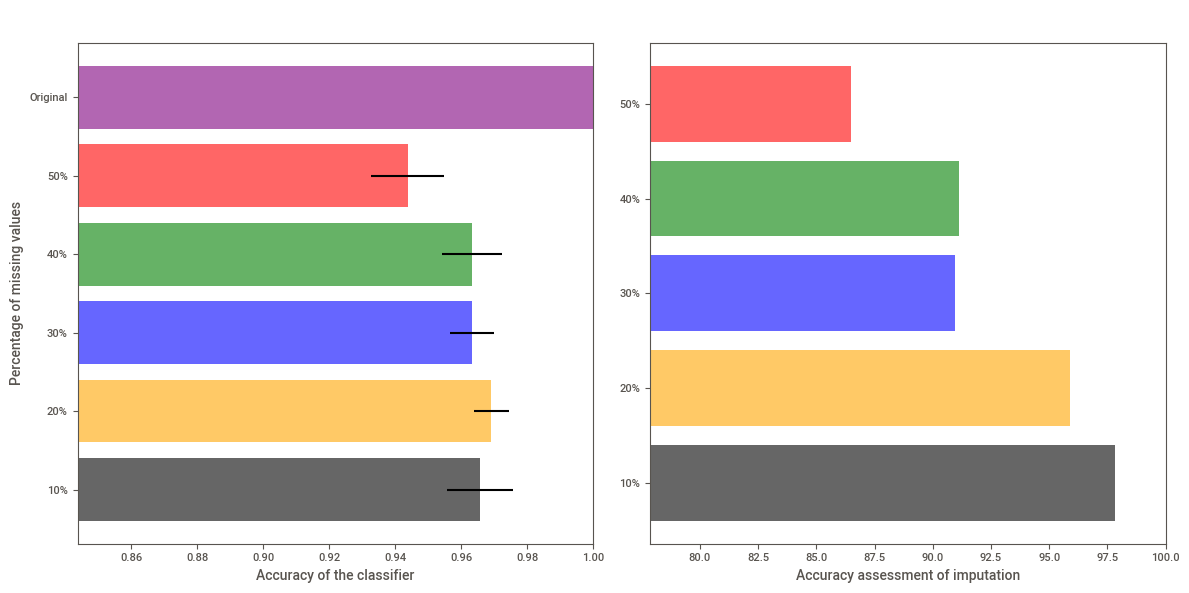

Accuracy of the classifier with complete data: 1.000 ± 0.000

Accuracy of the classifier with imputated data with 50% missing values: 0.944 ± 0.011
Accuracy of the classifier with imputated data with 40% missing values: 0.963 ± 0.009
Accuracy of the classifier with imputated data with 30% missing values: 0.963 ± 0.007
Accuracy of the classifier with imputated data with 20% missing values: 0.969 ± 0.005
Accuracy of the classifier with imputated data with 10% missing values: 0.966 ± 0.010

Accuracy assessment of imputation with 50% missing values: 86.506%
Accuracy assessment of imputation with 40% missing values: 91.128%
Accuracy assessment of imputation with 30% missing values: 90.975%
Accuracy assessment of imputation with 20% missing values: 95.871%
Accuracy assessment of imputation with 10% missing values: 97.840%


In [427]:
imputer = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=seed,
    ), 
    initial_strategy='most_frequent',
    max_iter=10, 
    add_indicator=True,
    random_state=seed
)

svc = SVC(random_state=seed)

imp = ImputationCategorical(
    name="KNNImputer",
    imputer=imputer,
    classifier=svc
)
imp.get_scores_for_full_dataset(mush_df, dirty_mush)
imp.plot_imputation(acc_original, std_original)
imp.print_imputation(acc_original, std_original)

# Other scores

In [39]:
from sklearn.model_selection import cross_validate

def get_imputed_all_scores(imputer, classifier, X_missing, y_missing):
    estimator = make_pipeline(imputer, classifier)
    # Accuracy of the classifier with imputated data
    impute_scores = cross_validate(
        estimator,
        X_missing, 
        y_missing, 
        scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
        cv=4
    )
    results = {}
    
    results["Accuracy"] = np.mean(impute_scores["test_accuracy"])
    results["Precision"] = np.mean(impute_scores["test_precision_macro"])
    results["Recall"] = np.mean(impute_scores["test_recall_macro"])
    results["F1"] = np.mean(impute_scores["test_f1_macro"])
    results["ROC AUC"] = np.mean(impute_scores["test_roc_auc"])
    
    return results

In [40]:
def get_full_all_scores(classifier, X_full, y_full):
    impute_scores = cross_validate(
        classifier,
        X_full, 
        y_full, 
        scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
        cv=4
    )

    results = {}
    
    results["Accuracy"] = np.mean(impute_scores["test_accuracy"])
    results["Precision"] = np.mean(impute_scores["test_precision_macro"])
    results["Recall"] = np.mean(impute_scores["test_recall_macro"])
    results["F1"] = np.mean(impute_scores["test_f1_macro"])
    results["ROC AUC"] = np.mean(impute_scores["test_roc_auc"])
    
    return results

In [41]:
percentages = ["50%", "40%", "30%", "20%", "10%"]
# Evaluate various classifiers and imputers
classifiers = [
    LogisticRegression(random_state=seed),
    SVC(random_state=seed),
    GradientBoostingClassifier(random_state=seed)
]

simple_imputers = [
    "most_frequent"
]

adv_imputers = [
    IterativeImputer(
        estimator=KNeighborsClassifier(n_neighbors=1),
        initial_strategy='most_frequent',
        max_iter=10, 
        random_state=seed
    ),
    IterativeImputer(
        estimator=RandomForestClassifier(
            n_estimators=4,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            n_jobs=2,
            random_state=seed,
            ), 
        initial_strategy='most_frequent',
        max_iter=10, 
        random_state=seed
    )
]

results_original = pd.DataFrame(
    index=[classifier.__class__.__name__ for classifier in classifiers],
    columns=["Accuracy", "Recall", "Precision", "F1", "ROC AUC"]
)

results_imputed = pd.DataFrame(
    index=[classifier.__class__.__name__ for classifier in classifiers], 
    columns=pd.MultiIndex.from_product([
        percentages, 
        simple_imputers + [(imputer.__class__.__name__ + (("_" + imputer.estimator.__class__.__name__) if hasattr(imputer, "estimator") else "")) 
                            for imputer in adv_imputers], 
        ["Accuracy", "Recall", "Precision", "F1", "ROC AUC"]
    ])
)


# Encoding of the data
encoder = OrdinalEncoder()
mush_df_encoded = encoder.fit_transform(mush_df)

for classifier in classifiers:
    # Original dataset
    X_full = mush_df_encoded[:, :-1]
    y_full = mush_df_encoded[:, -1]
    results_full = get_full_all_scores(classifier, X_full, y_full)
    for metric in results_full:
        results_original.loc[classifier.__class__.__name__,
                                metric] = results_full[metric]     
    
    print('\n\nClassifier: '+str(classifier))
    # Imputed dataset
    for percentage, dirty_df in zip(percentages, dirty_mush):
        dirty_np = encoder.fit_transform(dirty_df)
        for s_imputer in simple_imputers:
            X_dirty = dirty_np[:, :-1]
            y_dirty = dirty_np[:, -1]
            results_imp = get_imputed_all_scores(SimpleImputer(strategy=s_imputer), classifier, X_dirty, y_dirty)
        
            for metric in results_imp:
                results_imputed.loc[classifier.__class__.__name__,
                                    (percentage, s_imputer, metric)] = results_imp[metric]
            print('\nImputer: '+str(s_imputer))
        for a_imputer in adv_imputers:
            X_dirty = dirty_np[:, :-1]
            y_dirty = dirty_np[:, -1]
            results_imp = get_imputed_all_scores(a_imputer, classifier, X_dirty, y_dirty)
        
            for metric in results_imp:
                results_imputed.loc[classifier.__class__.__name__,
                                    (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), metric)] = results_imp[metric]
            print('\nImputer: '+str(a_imputer))
# save dataframes to csv
results_original.to_csv("mushrooms_class_original.csv")
results_imputed.to_csv("mushrooms_class_imputed.csv")


Classifier: LogisticRegression(random_state=42)


Imputer: most_frequent

Imputer: IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=1),
                 initial_strategy='most_frequent', random_state=42)

Imputer: IterativeImputer(estimator=RandomForestClassifier(max_depth=10, max_samples=0.5,
                                                  n_estimators=4, n_jobs=2,
                                                  random_state=42),
                 initial_strategy='most_frequent', random_state=42)

Imputer: most_frequent

Imputer: IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=1),
                 initial_strategy='most_frequent', random_state=42)

Imputer: IterativeImputer(estimator=RandomForestClassifier(max_depth=10, max_samples=0.5,
                                                  n_estimators=4, n_jobs=2,
                                                  random_state=42),
                 initial_strategy='most_frequent', random_state=42)

Imputer: mo

In [44]:
results_original

,Accuracy,Recall,Precision,F1,ROC AUC
LogisticRegression,0.938805,0.9384,0.939369,0.938697,0.977258
SVC,0.982086,0.98196,0.982233,0.982065,0.998826
GradientBoostingClassifier,1.0,1.0,1.0,1.0,1.0


In [50]:
# Print the results for [Classifier, Imputer]
results_imputed_lr_mean = results_imputed.loc["GradientBoostingClassifier", (slice(None), "IterativeImputer_RandomForestClassifier", slice(None))]
results_imputed_lr_mean

50%  IterativeImputer_RandomForestClassifier  Accuracy      0.96617
                                              Recall       0.965891
                                              Precision    0.966646
                                              F1            0.96612
                                              ROC AUC      0.991009
40%  IterativeImputer_RandomForestClassifier  Accuracy     0.988063
                                              Recall       0.987848
                                              Precision    0.988402
                                              F1           0.988045
                                              ROC AUC      0.997351
30%  IterativeImputer_RandomForestClassifier  Accuracy     0.996021
                                              Recall       0.995991
                                              Precision    0.996063
                                              F1           0.996017
                                              RO

In [51]:
results_imputed_lr_mean = results_imputed_lr_mean.unstack(level=0)
results_imputed_lr_mean

10%       20%  \
IterativeImputer_RandomForestClassifier Accuracy   0.998507  0.997511   
                                        F1         0.998506  0.997508   
                                        Precision  0.998554  0.997572   
                                        ROC AUC    0.999988  0.999988   
                                        Recall     0.998463  0.997466   

                                                        30%       40%  \
IterativeImputer_RandomForestClassifier Accuracy   0.996021  0.988063   
                                        F1         0.996017  0.988045   
                                        Precision  0.996063  0.988402   
                                        ROC AUC    0.999456  0.997351   
                                        Recall     0.995991  0.987848   

                                                        50%  
IterativeImputer_RandomForestClassifier Accuracy    0.96617  
                                        F1          0.96612  
                                        Precision  0.966646  
                                        ROC AUC    0.991009  
                                        Recall     0.965891